In [1]:
import torch
from torchvision import datasets, transforms
from models.nn import *
import matplotlib.pyplot as plt
from models.utils import *

In [2]:
# set the random seed
torch.manual_seed(0)
np.random.seed(0)

In [3]:
loss_fn = 'DV_loss' # NWJ_loss ; DV_loss ; NCE_loss; PCM_loss
miest_type = 'all' # 'l1'
img_size = 32
reg = True
refbatch = True
test_labels = 10
n_classes = 10

In [4]:
# load the data
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# load mnist
train_dataset = datasets.MNIST('../projects/data/', train=True, download=True, transform=transform)

In [5]:
grouped_data = {label: [] for label in range(10)}
train_loaders = []

# group the data
for data in train_dataset:
    label = data[1]
    grouped_data[label].append(data)

class_batch_size = 100
for c in range(test_labels):
    train_loaders.append(torch.utils.data.DataLoader(grouped_data[c], batch_size=class_batch_size, shuffle=True))

# construct the train dataset: X, Y are i.i.d. samples from the same class
X = []
Y = []
for c in range(test_labels):
    # for _ in range(10):
    data1, _ = next(iter(train_loaders[c]))
    data2, _ = next(iter(train_loaders[c]))
    X.append(data1)
    Y.append(data2)

X = torch.cat(X)
Y = torch.cat(Y)
XY = torch.cat((X, Y), dim=1)

In [10]:
# move to GPU
net = DNN_Net(input_size=(n_classes+2)*2)
discriminator = Discriminator(img_size=img_size, code_dim=2)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0002, betas=(0.5, 0.999))

if torch.cuda.is_available():
    X = X.cuda()
    Y = Y.cuda()
    XY = XY.cuda()
    discriminator.cuda()
    net.cuda()

# load the discriminator
discriminator.load_state_dict(torch.load('checkpoints/cont2dist10discriminator_199.pt'))

<All keys matched successfully>

In [7]:
def code(encoder, data):
    """Obtain the codes from the pixel data.count

    Args:
        - encoder: the encoder of InfoGAN model Q(c|X)
        - data: pixel data

    Return:
        The codes/representation of data.
    """
    _, _, latent_code = encoder(data)
    return torch.cat((latent_code, encoder.aux_layer[0](discriminator.conv_blocks(X).reshape(X.shape[0], -1))), dim=1)


def DV_loss(D, x, y, y_ref=None, reg=False, alpha=1.0):
    '''
    D: discriminator
    x: data x
    y: data y
    '''
    # reshuffle y and concatenate with x
    joint_xy = torch.cat((x, y), dim=1)
    if y_ref is None:
        x_tile = x.unsqueeze(0).repeat((y.shape[0], 1, 1))
        y_tile = y.unsqueeze(1).repeat((1, x.shape[0], 1))
        marginal_xy = torch.cat((x_tile, y_tile), dim=-1).view(x.shape[0]*y.shape[0], -1)
    else:
        x_tile = x.unsqueeze(0).repeat((y_ref.shape[0], 1, 1))
        y_tile = y_ref.unsqueeze(1).repeat((1, x.shape[0], 1))
        marginal_xy = torch.cat((x_tile, y_tile), dim=-1).view(x.shape[0]*y_ref.shape[0], -1)

    if reg:
        return -D(joint_xy.view(joint_xy.size(0), -1)).mean() + torch.logsumexp(D(marginal_xy.view(marginal_xy.size(0), -1)), dim=0).mean() - np.log(marginal_xy.shape[0]) + alpha*(torch.logsumexp(D(marginal_xy.view(marginal_xy.size(0), -1)), dim=0).mean() - np.log(marginal_xy.shape[0]))**2
    else:
        return - D(joint_xy.view(joint_xy.size(0), -1)).mean() + torch.logsumexp(D(marginal_xy.view(marginal_xy.size(0), -1)), dim=0).mean() - np.log(marginal_xy.shape[0])

def sigmoid(x, tau=1):
    return 1 / (1 + torch.exp(-x/tau))

In [11]:
with torch.no_grad():
    code_X = sigmoid(code(discriminator, X))
    code_Y = sigmoid(code(discriminator, Y))

In [12]:
# dis_mi = mutual_information(dis_codeX.cpu(), dis_codeY.cpu())
max_iter = 20000
batch_size = 40
ref_batch_size = batch_size
mi_list = []
for i in range(max_iter):
    # draw mini-batch data
    idx = resample(X, batch_size, return_idx=True)

    # train
    optimizer.zero_grad()
    if refbatch:
        idx_ref = resample(Y, ref_batch_size, return_idx=True)
        batch_codex = code_X[idx]
        batch_codey = code_Y[idx]
        refbatch_codey = code_Y[idx_ref]
        loss = eval(loss_fn)(net, batch_codex, batch_codey, refbatch_codey, reg=reg)
    else:
        loss = eval(loss_fn)(net, batch_codex, batch_codey, reg=reg)
    loss.backward()

    # torch.nn.utils.clip_grad_norm_(net.parameters(), 0.02)
    optimizer.step()
    with torch.no_grad():
        if miest_type == 'all':
            mi_list.append(-eval(loss_fn)(net, code_X, code_Y).item())
        elif miest_type == 'l1':
            mi_list.append(mi_estimate(net, torch.cat((code_X, code_Y), dim=1)).item())
    if i % 200 == 0:
        print('iter: {}, mi estimation: {}'.format(i, mi_list[-1]))

iter: 0, mi estimation: 5.7220458984375e-06
iter: 200, mi estimation: 0.0021724700927734375
iter: 400, mi estimation: 0.2106790542602539
iter: 600, mi estimation: 0.687952995300293
iter: 800, mi estimation: 0.9215316772460938
iter: 1000, mi estimation: 1.0758905410766602
iter: 1200, mi estimation: 1.1780433654785156
iter: 1400, mi estimation: 1.2644023895263672
iter: 1600, mi estimation: 1.3465394973754883
iter: 1800, mi estimation: 1.3844947814941406
iter: 2000, mi estimation: 1.4297294616699219
iter: 2200, mi estimation: 1.4613628387451172
iter: 2400, mi estimation: 1.4877433776855469
iter: 2600, mi estimation: 1.4964685440063477
iter: 2800, mi estimation: 1.4980888366699219
iter: 3000, mi estimation: 1.5284690856933594
iter: 3200, mi estimation: 1.5445318222045898
iter: 3400, mi estimation: 1.5571441650390625
iter: 3600, mi estimation: 1.5707807540893555
iter: 3800, mi estimation: 1.5504350662231445
iter: 4000, mi estimation: 1.5847368240356445
iter: 4200, mi estimation: 1.597492218

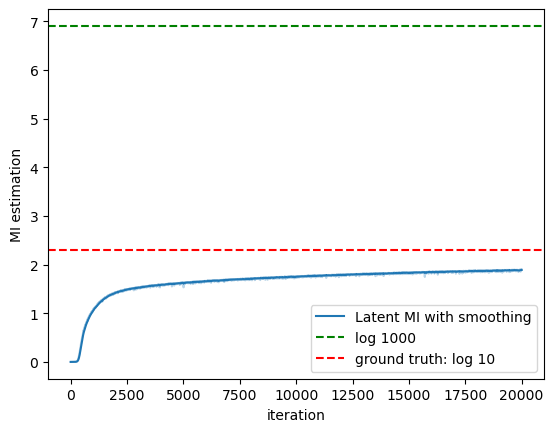

In [14]:
import pandas as pd
import math

EMA_SPAN = 50
p1 = plt.plot(mi_list, alpha=0.3)[0]
mis_smooth = pd.Series(mi_list).ewm(span=EMA_SPAN).mean()
plt.plot(mis_smooth, c=p1.get_color(), label='Latent MI with smoothing')
plt.axhline(math.log(XY.shape[0]), c='g', ls='--', label=f'log {XY.shape[0]}')
plt.axhline(math.log(test_labels), c='r', ls='--', label=f'ground truth: log {test_labels}')

plt.xlabel('iteration')
plt.ylabel('MI estimation')
plt.legend()
plt.show()
# torch.save(mi_list, f'./mi_list/quant_c{n_classes}codedim2.pt')